In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

Пропущенные значения:
Цена на арматуру    0
dtype: int64


<Figure size 1200x600 with 0 Axes>

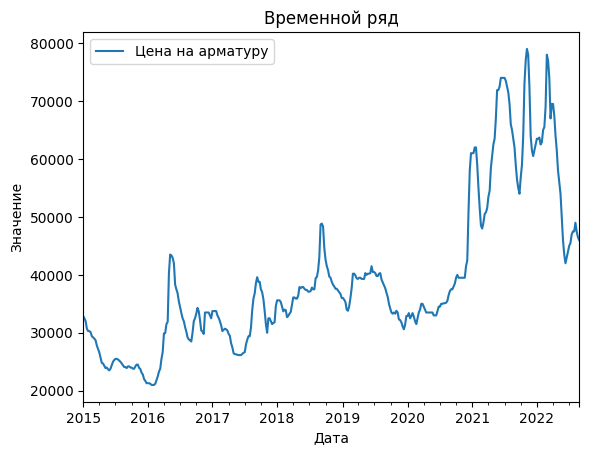

Результаты теста Дики-Фуллера:
p-value: 0.3199906102569917
Критические значения:
1%: -3.4470566389664703
5%: -2.8689037160476016
10%: -2.570692663557422


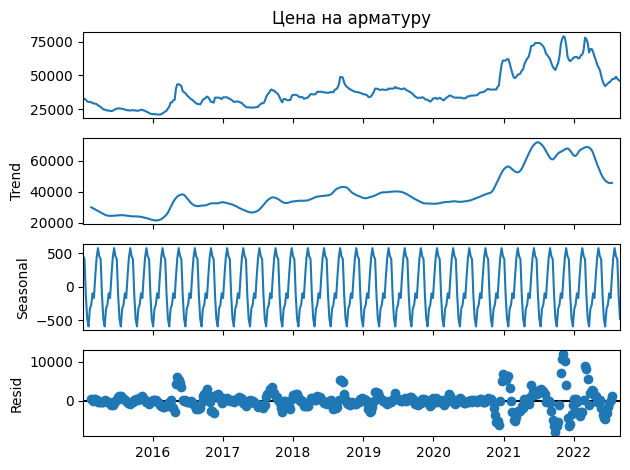

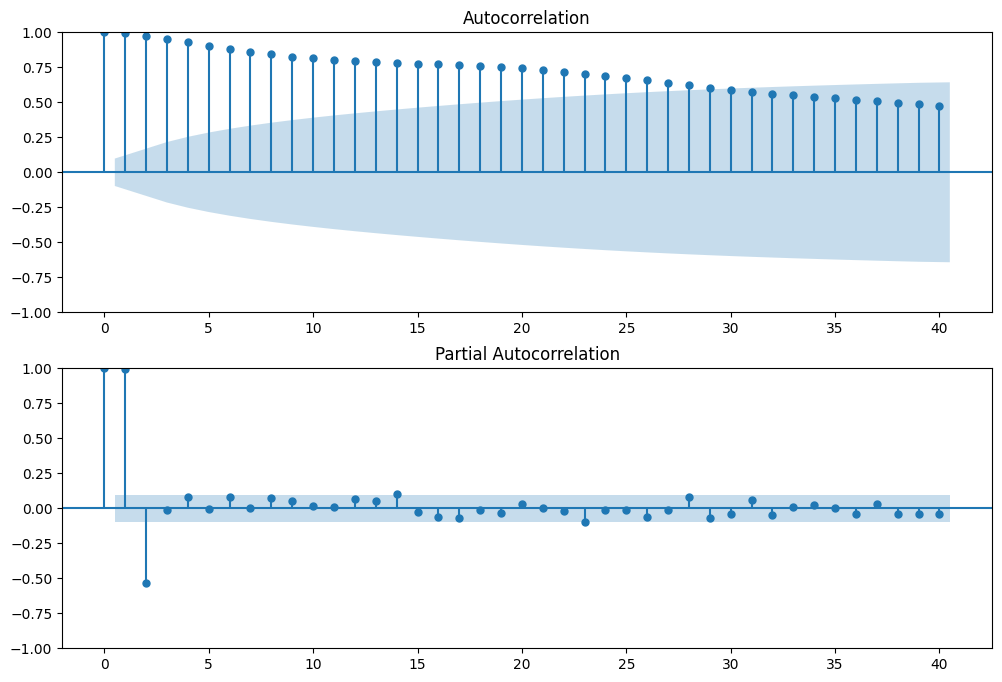

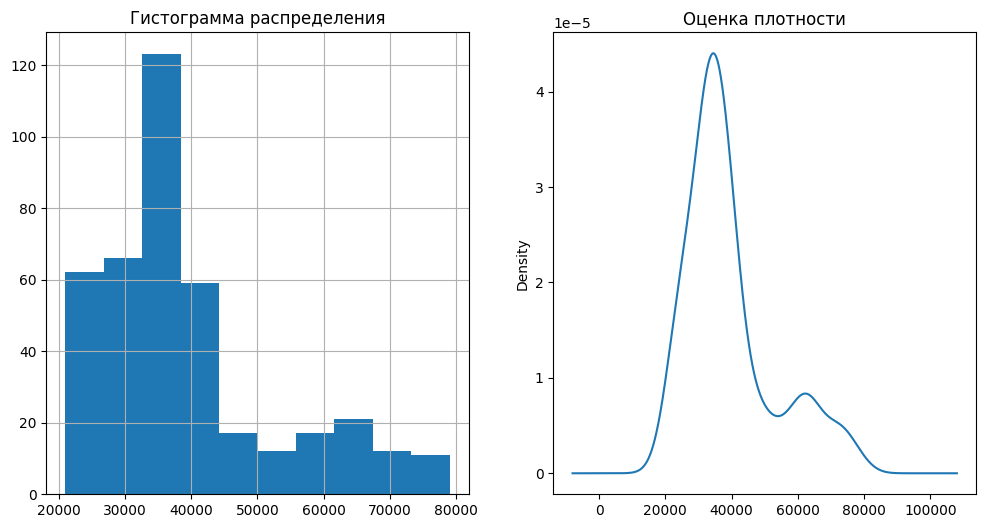

In [35]:
# 1. Загрузка данных
df = pd.read_excel(r'C:\Users\Евгения\Desktop\reinforcement_task\data\train.xlsx', parse_dates=['dt'], index_col='dt')

# 2. Проверка пропусков
print("Пропущенные значения:")
print(df.isnull().sum())

# 3. Визуализация ряда
plt.figure(figsize=(12,6))
df.plot(title='Временной ряд')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.show()

# 4. Проверка стационарности (тест Дики-Фуллера)
def test_stationarity(timeseries):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'p-value: {dftest[1]}')
    print(f'Критические значения:')
    for key, val in dftest[4].items():
        print(f'{key}: {val}')
        
test_stationarity(df['Цена на арматуру'])

# 5. Декомпозиция ряда
result = seasonal_decompose(df['Цена на арматуру'], model='additive', period=12)
result.plot()
plt.show()

# 6. Автокорреляция
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['Цена на арматуру'].dropna(), lags=40, ax=ax1)
plot_pacf(df['Цена на арматуру'].dropna(), lags=40, ax=ax2)
plt.show()

# 7. Анализ распределения
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
df['Цена на арматуру'].hist()
plt.title('Гистограмма распределения')
plt.subplot(1,2,2)
df['Цена на арматуру'].plot(kind='kde')
plt.title('Оценка плотности')
plt.show()

# Основные выводы

## Нестационарность ряда:
- **Тест Дики-Фуллера** показал:
  - p-value = 0.32 
  - Критические значения:
    - 1%: -3.45
    - 5%: -2.87
    - 10%: -2.57
- **Вывод**: ряд нестационарен (присутствуют тренд и/или сезонность)

## Сезонная декомпозиция:
- Четкий сезонный компонент:
  - Амплитуда ±500
- Остатки (Resid):
  - Сильные отклонения в 2020-2022 гг.
  - Возможные причины: пандемия, изменения рынка

## Автокорреляция (ACF/PACF):
- **ACF**:
  - Медленное затухание → подтверждение нестационарности
- **PACF**:
  - Значимые пики на первых лагах
  - Рекомендация: дифференцирование (первая разница)

## Распределение данных:
- Гистограмма и плотность показывают:
  - Правосторонняя асимметрия
  - Смещение к высоким значениям
- **Рекомендация**:
  - Преобразование данных (логарифмирование)

In [36]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
# 1. Загрузка и объединение данных
train = pd.read_excel('train.xlsx', parse_dates=['dt'])
test = pd.read_excel('test.xlsx', parse_dates=['dt'])
full_data = pd.concat([train, test]).sort_values('dt').reset_index(drop=True)

# корректно создать лаги (сдвиги) и временные фичи для всего временного диапазона.
# Исключить риск "утечки данных" при разделении на train/test после обработки.

In [38]:
# 2. Создание лагов и фичей на основе даты
# Логарифмирование для устранения асимметрии
full_data['log_price'] = np.log(full_data['Цена на арматуру'])
#  уменьшение асимметрии (скошенности) распределения целевой переменной

# Создание лагов
for lag in [1, 2]:
    full_data[f'lag_{lag}'] = full_data['log_price'].shift(lag)
# использование исторических значений цены для прогнозирования будущих

# Создание временных фичей
full_data['month'] = full_data['dt'].dt.month
full_data['quarter'] = full_data['dt'].dt.quarter
full_data['year'] = full_data['dt'].dt.year
# чтобы учесть сезонность и долгосрочные тренды

# Удаление пропусков после создания лагов
full_data = full_data.dropna()

# 2.5 Экспорт полного датасета с фичами для последующего использования в приложении
full_data[['dt', 'Цена на арматуру', 'log_price', 'lag_1', 'lag_2', 'month', 'quarter', 'year']].to_csv(
    'historical_data.csv', 
    index=False,
    encoding='utf-8-sig'  # для корректного отображения русских символов
)

In [39]:
# 3. Разделение на обучающую и тестовую выборки (без перемешивания)
X = full_data.drop(['Цена на арматуру', 'log_price', 'dt'], axis=1)
y = full_data['log_price']

# Выбор индексов для разделения
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [40]:
# 4. Обучение ансамбля моделей
# Random Forest с регуляризацией
rf = RandomForestRegressor(
    n_estimators=200,  # Уменьшить количество деревьев
    max_depth=3,       # Снизить глубину
    min_samples_leaf=5,  # Добавить регуляризацию
    random_state=42
)
rf.fit(X_train, y_train)

# CatBoost с обработкой категорий и регуляризацией
catboost = CatBoostRegressor(
    iterations=400,    # Уменьшить итерации
    depth=3,           # Снизить глубину
    learning_rate=0.05,  # Меньше скорость обучения
    l2_leaf_reg=5,     # Добавить L2-регуляризацию
    cat_features=['month', 'quarter', 'year'],
    silent=True
)

catboost.fit(X_train, y_train)

# Ансамблирование (среднее предсказаний)
y_pred_rf = rf.predict(X_test)
y_pred_cat = catboost.predict(X_test)
y_pred = (y_pred_rf + y_pred_cat) / 2

# Обратное преобразование из логарифма
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

In [41]:
# 5. Расчет метрик
print(f"MAE: {mean_absolute_error(y_test_exp, y_pred_exp)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))}")
print(f"R²: {r2_score(y_test_exp, y_pred_exp)}")


MAE: 2980.027918123781
RMSE: 3913.802709136952
R²: 0.883097934666383


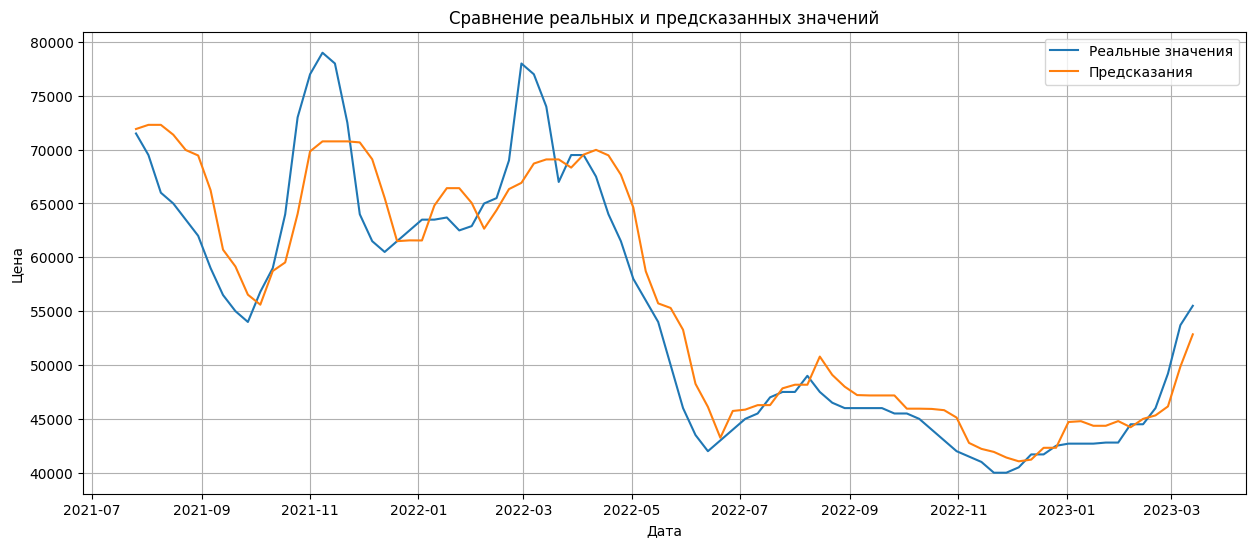

R² на обучении: 0.9861213833510537
R² на тесте: 0.883097934666383


In [42]:
# 6. Построение графиков
plt.figure(figsize=(15, 6))
plt.plot(full_data['dt'].iloc[split_idx:], y_test_exp, label='Реальные значения')
plt.plot(full_data['dt'].iloc[split_idx:], y_pred_exp, label='Предсказания')
plt.title('Сравнение реальных и предсказанных значений')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

# 7. Оценка на переобучение по R² - 0.10 небольшое переобучение, но допустимое для сложных данных (например, временных рядов)
train_pred = np.exp((rf.predict(X_train) + catboost.predict(X_train)) / 2)
print(f"R² на обучении: {r2_score(np.exp(y_train), train_pred)}")
print(f"R² на тесте: {r2_score(y_test_exp, y_pred_exp)}")


In [43]:
# 8. Сохранение моделей в pickle-файл
import joblib

# Сохраняем обе модели и мета-информацию в словарь
model_artifact = {
    'rf_model': rf,
    'catboost_model': catboost,
    'features_order': X_train.columns.tolist(),  # сохраняем порядок фичей
    'log_transform_info': 'Цена преобразована через np.log()'  # мета-информация
}

# Экспорт в файл 
# Сохранение модели в scaler1.pkl
joblib.dump(model_artifact, 'scaler1.pkl')

['scaler1.pkl']